# Crack Deflection quantification example notebook
Welcome! This jupyter interactive notebook is meant to be a starting point for those interested in using the code described in "Unraveling the effect of collagen damage on bone fracture using in situ synchrotron microtomography with deep learning".

Here, we downsampled one of the binary crack images from our study to use as a toy problem for crack deflection. The packages required to run the following code should be available in a .yaml file in the project repo on Github. See creating a conda environment for how to create an environment based on this file. We do use plotly in this notebook for crack visualization, but it is not necessary if you simply want to run an analysis without the 3D visualization.

In [140]:
# importing packages
import numpy as np
import pandas as pd
from Crack_Deflection import *
from Crack_Preprocess import get_stack_coord, process_no_crack, center_at_notch, preproc, get_median_coord
import matplotlib.pyplot as plt
from glob import glob
from numba import jit

import plotly.graph_objects as go
from scipy.spatial import Delaunay
import plotly.figure_factory as ff

from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.preprocessing import normalize, StandardScaler

## 1. Converting binary crack images to elevation map
In this step, we import he images of the crack (propagating in the z-direction) and process the image stack. We convert the images from a 3D array of binary values to a 2D array of values that correspond to the changing elevation of the crack surface.

The functions used here are imported from Crack_Preprocess.py in the repo. That code can be referenced to see what is going on behind the scenes. We also show the crack surface image in 2D where the color is based on the elevation of the crack below.

In [141]:
# get file names for scan
files = glob('./example_crack_imagestack/*') # downsampled image of binary crack

# get the coordinates of the crack surface
coord = get_stack_coord(files, use_nan=True)

# process areas with no crack
coord = process_no_crack(coord)

# center the deflections about the notch
coord = center_at_notch(coord)

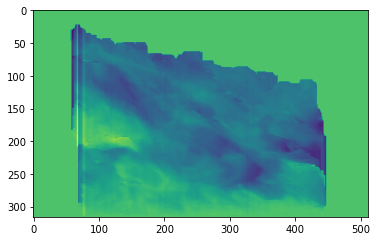

In [142]:
plt.imshow(coord)
plt.show()

## 2. Calculating the gradient of the crack surface
We use the numpy gradient function to calculate the gradient of the crack surface both from the side and from the top.
The rolling average of the gradient is applied to smooth the gradient of the crack surface, but this can be ignored if you would rather have the raw gradient. Additionally, the size of the rolling gradient can be adjusted with the "window" keyword argument. See the Crack_Deflection.py file for the exact function. 

Examples of that looks like are shown below as well.

In [143]:
# get gradient
crack_grad_side, crack_grad_top = np.gradient(coord)
# change direction so color map cooresponds to deflection
crack_grad_side, crack_grad_top = -1*crack_grad_side, -1*crack_grad_top

# apply rolling average to the side
crack_grad_side = apply_rolling_average(crack_grad_side)

# apply rolling average to the top
crack_grad_top = crack_grad_top.T
crack_grad_top = apply_rolling_average(crack_grad_top)
crack_grad_top = crack_grad_top.T

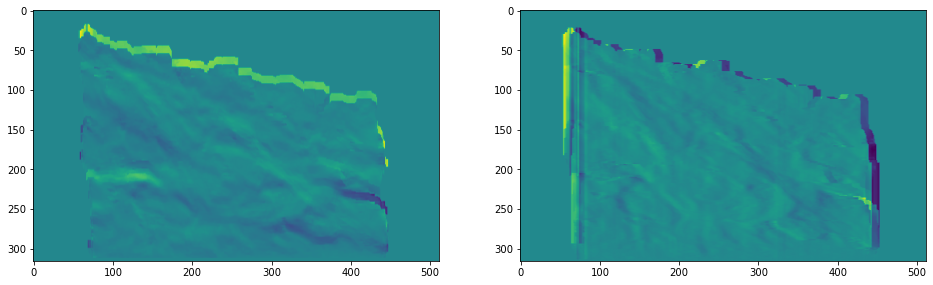

In [144]:
# visuallizing the gradient of the crack surface from 2 different directions (side and top)
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(crack_grad_side)
ax[1].imshow(crack_grad_top)
plt.show()

## 3. Cropping the crack to a relevant region-of-interest
Here, we take the background pixels that are not the crack out of the image and we also crop in the sides of the image so that the crack is in the full field-of-view of the image. The way we crop the sides is not very sophisticated, we just take 5% of the crack on the sides of the image and crop in. This may be improved in future work.

We then show the crack and its gradients below.

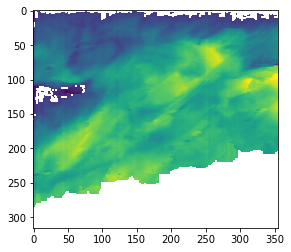

In [145]:
# shift to 0
coord2 = np.where(coord == 0, np.nan, coord) 
coord2 = np.flipud(coord2)

low_dim = np.isnan(coord2)
low_dim = low_dim == False
low_dim = low_dim.sum(axis=0)

cols = np.where(low_dim != 0)[0]
start = cols[0]
end = cols[-1]

# chop off
xrange = end - start
chop = 0.05
chop_ind = int(xrange*chop)
new_idx = cols[chop_ind:-chop_ind]
coord = -coord2[:,new_idx]

plt.imshow(coord)
plt.show()

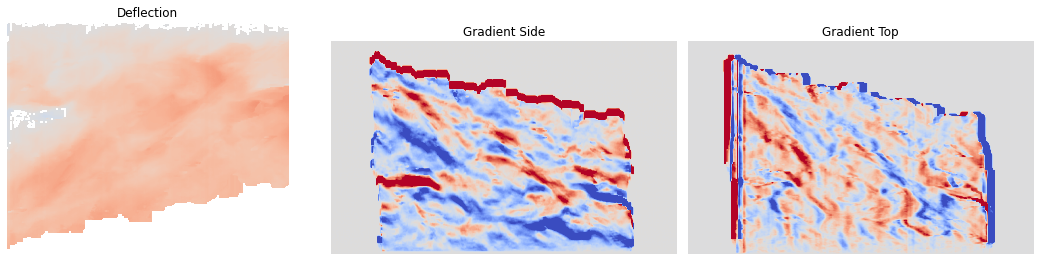

In [82]:
# set colormap
cmap='coolwarm'

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
v=200
ax[0].imshow(coord, cmap=cmap, vmin=-v, vmax=v)
v=2
ax[1].imshow(crack_grad_side, cmap=cmap, vmin=-v, vmax=v)
v=2
ax[2].imshow(crack_grad_top, cmap=cmap, vmin=-v, vmax=v)

for i, title in enumerate(['Deflection', 'Gradient Side', 'Gradient Top']):
    ax[i].set_title(title)

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()

## 4. Visualizing the crack surface in 3D
Not strictly necessary, but we can visualize the crack surface in 3D using plotly. You can also freely interact with the crack surface. While you can do the same thing with the original CT scans in many software, this is cool to see the crack simplified into a simple surface. We will do more with this in the future as well. To get it set up, we have to organize the data into a meshgrid format, but it's not too bad.

Following that, we use delaunay trianglulation and a trisurf to visualize it. While the edges of the crack surface are not ideal visually, the surface should be quite accurate. Feel free to interact with it and see how the crack deflects and twists as it propagates.

In [146]:
x, y = coord.shape
idx = ~np.isnan(coord)
xx, yy = np.meshgrid(np.arange(y), np.arange(x))
crack_x = xx[idx][::50]
# crack_y = np.flip(yy[idx][::100])
crack_y = yy[idx][::50]
crack_z = coord[idx][::50]

xrange = max(crack_x) - min(crack_x)
yrange = max(crack_y) - min(crack_y)
zrange = max(crack_z) - min(crack_z)
# print(xrange,yrange,zrange)
ratios = np.array([xrange, yrange, zrange])/xrange
aspect = {'x':ratios[0], 'y':ratios[1], 'z':ratios[2]}
# print(aspect)

# uncomment if you want to see scatter
# scatter = [go.Scatter3d(z=crack_z, x=crack_x, y=crack_y, mode='markers', marker=dict(size=3))]
# Fig = go.Figure(data=scatter)
# Fig.show()

In [147]:
points2D = np.vstack([crack_x, crack_y]).T
tri = Delaunay(points2D)
simplices = tri.simplices
triplot = ff.create_trisurf(x=crack_x, y=crack_y, z=crack_z, simplices=simplices, colormap="RdBu", 
                        aspectratio=aspect)
# future work: potentially clean up the edges of the trisurf by taking out simplices
# also make own colorbar

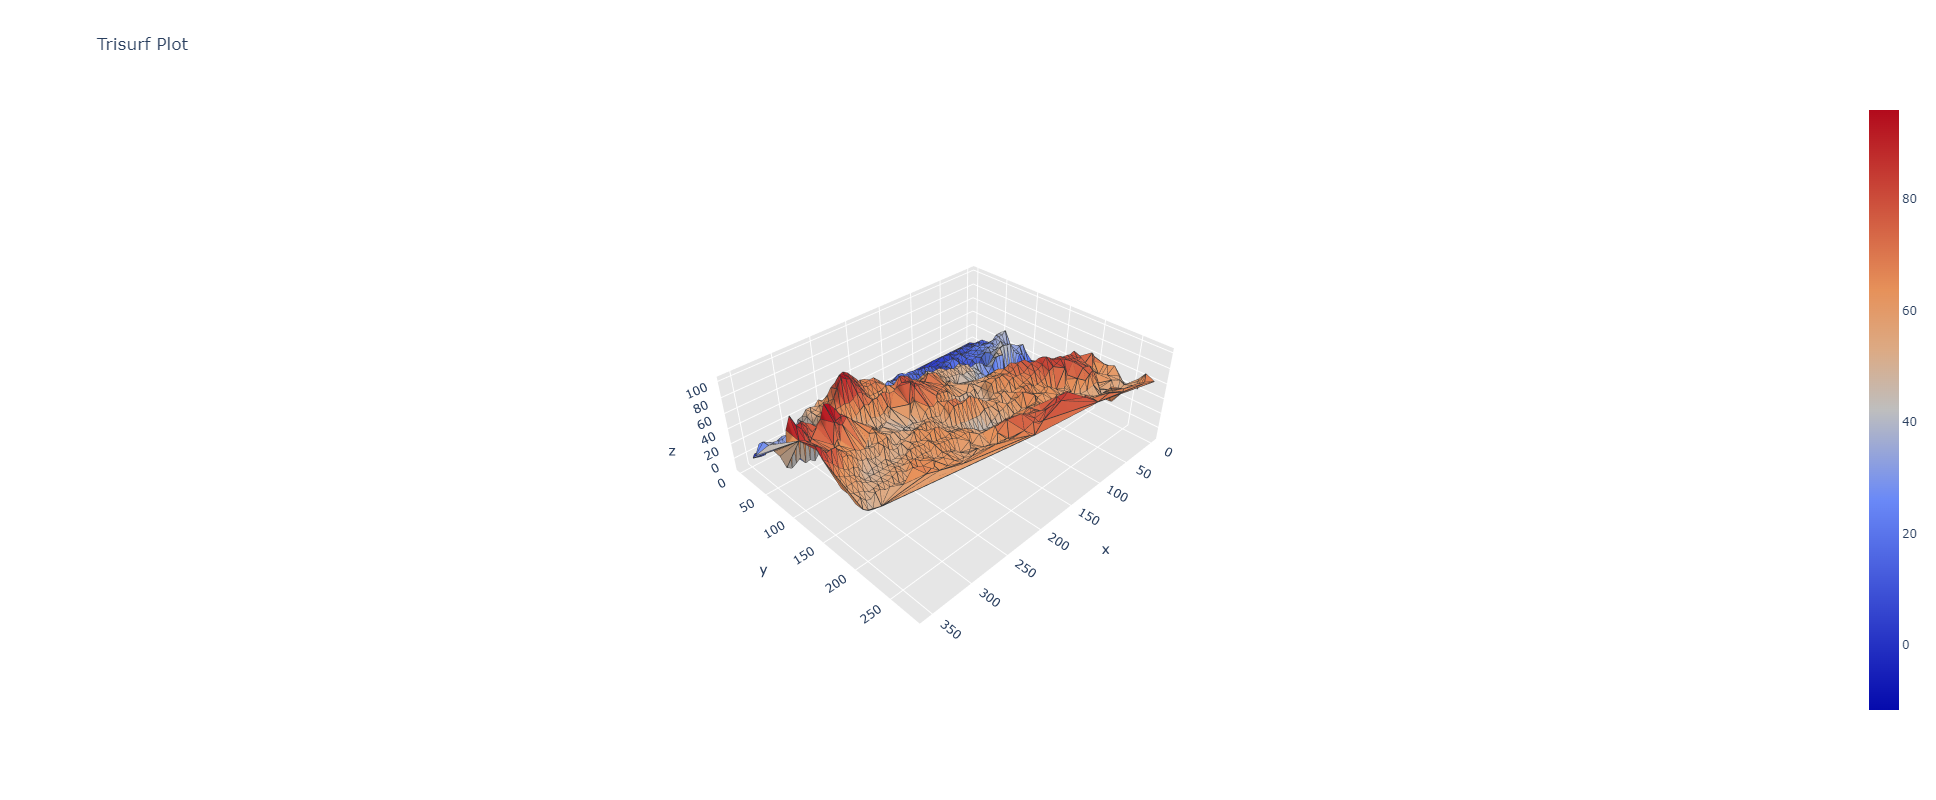

In [148]:
Fig = go.Figure(data=triplot)
Fig.show()

## 5. Calculating the points of crack deflection
This step of calculating and quantifying the crack deflections is the meat of this notebook. We first look at the crack deflections of a single crack profile (crack cross-section sliced in the direction of crack propagation), and then apply the process for the whole crack. First, let's go through the process for a single crack profile.

First, we take the rolling average of the crack gradient (you can change the window as you like) and find when the gradient changes sign. These are marked by the dotted line on the plot of the crack profile. how much you smooth the crack gradient will influence how little changes in the crack surface will count as a change in the sign. We will filter small deflections in the future, so no need to worry if it looks like there are way too many deflections that you would not classify by hand.

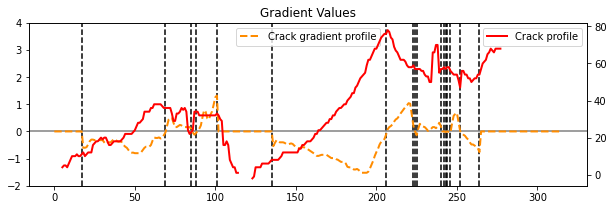

CPU times: total: 406 ms
Wall time: 407 ms


In [166]:
%%time
# testing the functions and go faster
img_idx = 20
# getting large deflection sections
# get gradient
test = np.where(coord == 0, np.nan, coord)
crack_grad_side = np.gradient(test, axis=0)
# change direction so color map cooresponds to deflection
crack_grad_side = -1*crack_grad_side
# apply rolling average to the side (larger window)
window=25
crack_grad_side2 = apply_rolling_average(crack_grad_side.copy(), window=window)

# put this in the loop
c_grad_val = crack_grad_side2[:, img_idx]
deflect_points = get_sections(c_grad_val, img_idx)

true_deflect_points = deflect_points

fig, ax = plt.subplots(figsize=(10, 3))
for p in deflect_points:
    plt.axvline(x=p, color='k', linestyle='--')
plt.axhline(y=0, color='k', alpha=0.5)
# ax.plot(np.flip(crack_grad_side[:,img_idx])*0.4, linestyle='--')
ax.plot(np.arange(len(coord[:,img_idx])), c_grad_val, 'darkorange', linestyle='--', linewidth=2, label="Crack gradient profile")
ax2 = ax.twinx()
ax2.plot(np.arange(len(coord[:,img_idx])), coord[:,img_idx], 'r', linewidth=2, label="Crack profile")
plt.title('Gradient Values')
ax.set_ylim([-2,4])
ax.legend()
ax2.legend()
plt.show()

## 6. Calculating the magnitude and the direction of the crack deflection
The magnitude and direction of the crack deflection are determined by looking at the angle of each deflection to the next. These vectors are shown in context of the crack profile below. 

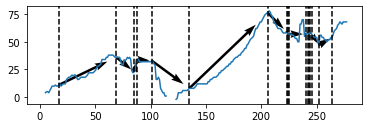

CPU times: total: 109 ms
Wall time: 103 ms


In [155]:
%%time
z_vals = coord[:,img_idx]

start = 0
angles = np.zeros(len(true_deflect_points))
vectors_o = np.zeros((len(true_deflect_points),2))
vectors_u = np.zeros(len(true_deflect_points))
vectors_v = np.zeros(len(true_deflect_points))
for i, section in enumerate(true_deflect_points):
    end = int(section)
    z_change = z_vals[end] - z_vals[start] # up and down change
    x_change = end - start
    vectors_o[i,:] = start, z_vals[start]
    vectors_u[i] = x_change
    vectors_v[i] = z_change
    angle = np.arctan(z_change/x_change)
    angles[i] = angle*180/np.pi
    start = int(section)
    
fig, ax = plt.subplots()
plt.plot(np.arange(len(z_vals)), z_vals)
for p in true_deflect_points:
    plt.axvline(x=p, color='k', linestyle='--')
# print(angles)
plt.quiver(vectors_o[:,0], vectors_o[:,1],  vectors_u, vectors_v)
ax.set_aspect(1)
plt.show()

# need a better way to calculate the end point of delfection

## 7. Applying the same process as above for the whole crack surface now
Now we will apply this process for all the crack profiles. Here we also apply an angle threshold and a deflection vector magnitude threshold. These take out delfections whose angles are too shallow or too small.

In [157]:
%%time
step = 5
# getting the angles and the vectors for increments of 10 slices
num_imgs = coord.shape[1]
slices = np.arange(num_imgs)[::step]
all_deflects = []
angle_info = []

test = np.where(coord == 0, np.nan, coord)
crack_grad_side = np.gradient(test, axis=0)
# change direction so color map cooresponds to deflection
crack_grad_side = -1*crack_grad_side
# apply rolling average to the side (larger window)
crack_grad_side2 = apply_rolling_average(crack_grad_side.copy(), window=50)

for num in slices:
    deflect_points = get_sections(crack_grad_side2[:, num], num)
    all_deflects.append(deflect_points)
    angles, vectors_o, vectors_u, vectors_v = get_angles(coord, num, deflect_points)
    angle_info.append((angles, vectors_o, vectors_u, vectors_v))

CPU times: total: 188 ms
Wall time: 178 ms


In [158]:
angle_thresh = 35
mag_thresh = 30

a, x3d, y3d, z3d, u3d, v3d, w3d = [], [], [], [], [], [], []

for i, info in enumerate(angle_info):
    if len(info[1]) == 0:
        continue
#     print(coord[])
    a.append(info[0])
    y3d.append(info[1][:,0])
    z3d.append(info[1][:,1])
    x3d.append([slices[i]]*len(info[1]))
    v3d.append(info[2])
    w3d.append(info[3])
    u3d.append([0]*len(info[2]))

a3d = np.hstack(a)
x3d = np.hstack(x3d)
y3d = np.hstack(y3d)
z3d = np.hstack(z3d)
u3d = np.hstack(u3d)
v3d = np.hstack(v3d)
w3d = np.hstack(w3d)

idx1 = np.abs(a3d) > angle_thresh
mag = np.linalg.norm(np.array([u3d,v3d,w3d]), axis=0)
idx2 = mag > mag_thresh
idx_final = np.logical_and(idx1, idx2)
a3d = a3d[idx_final]
x3d = x3d[idx_final]
y3d = y3d[idx_final]
z3d = z3d[idx_final]
u3d = u3d[idx_final]
v3d = v3d[idx_final]
w3d = w3d[idx_final]
mag3d = mag[idx_final]

## 8. Clustering groups of large scale deflections
Here, we take all the deflections that the above steps gave to us and group then using the OPTICS clustering method in sci-kit learn. We put pertinent features that we want to cluster the deflections by in a dataframe (xy location and deflection angle). The clustering algorithm will then group them using some initial parameters. We recommend you to look at the documentation of the optics model in scikit learn and tune the parameters to best fit the model you are working with. For this example, we have chosen the following parameters, but the best parameters may change with the resolution of the data.

We show visually below the deflections as points on a scatter plot, color-coded by groups of deflection that the optics algorithm clustered. On the left are all the deflections, and on the right are only the clusters, with unclassified point being ignored. The same parameters are ran with all the data and the number of clusters and their mean angle are compared for the final analysis of crack deflections.


[-1  0  1  2  3  4  5  6  7]


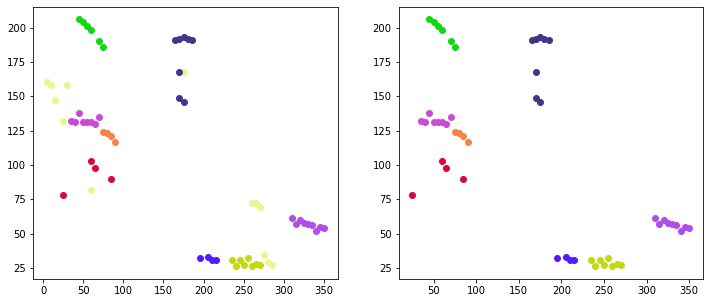

In [161]:
df = pd.DataFrame(dict(angle=a3d, x=x3d, y=y3d))

# Building the OPTICS Clustering model
optics_model = OPTICS(min_samples=3, xi=0.05, min_cluster_size=4)
# Training the model
# optics_model.fit(df_normalized)
optics_model.fit(df)

idxs = optics_model.ordering_
labels = optics_model.labels_[idxs]
# Plotting the OPTICS Clustering
unique = np.unique(labels)
print(unique)
label_idx = []
fig, ax = plt.subplots(1,2, figsize=(12,5))
for label in unique:
    color = tuple(np.random.choice(np.linspace(0,1,256), size=3))
    idx_lab = labels == label
    idx_true = idxs[idx_lab]
    label_idx.append(idx_true)
    ax[0].scatter(x3d[idx_true], y3d[idx_true], color=color)
    if label != -1:
        ax[1].scatter(x3d[idx_true], y3d[idx_true], color=color)
# print(optics_model.ordering_)

## Extra: visualization of the crack deflections
We also use the same visualization that we used for the crack earlier and superimpose the crack deflection clusters that we've found so that we can easily see if the results that we've found are as we would expect. If you feel like the delfections are not being captured as you'd anticipate for your crack dataset, you may chose to tune the parameters of this example script to best suit the image spacing of your dataset. Once you have tuned the hyperparameters to capture the deflections as you'd expect, you can apply that model to your entire dataset.

In [162]:
d_labels = unique[1:]
i_labels = label_idx[1:]
mean_angles = []
mean_mags = []
for clust in range(len(d_labels)):
    c_idx = i_labels[clust]
    c_angles = a3d[c_idx]
    c_mag = mag3d[c_idx]
    mean_angles.append(np.mean(c_angles))
    mean_mags.append(np.mean(c_mag))
    
# print(mean_angles, mean_mags)
labeled = np.hstack(i_labels)
a3d = a3d[labeled]
x3d = x3d[labeled]
y3d = y3d[labeled]
z3d = z3d[labeled] + 10
u3d = u3d[labeled]
v3d = v3d[labeled]
w3d = w3d[labeled]
mag3d = mag[labeled]

print(mean_angles)
print(mean_mags)

[45.380956616262075, 47.53205932237495, -44.91210921717658, -39.925420778772825, 32.40394778030526, 36.8926385256884, 53.622374097169214, 42.51546304475242]
[98.01037494030032, 88.89277098588882, 50.866635520921335, 52.0939769410276, 39.102291688801685, 95.36179857298247, 80.59995196130633, 74.52203478700648]


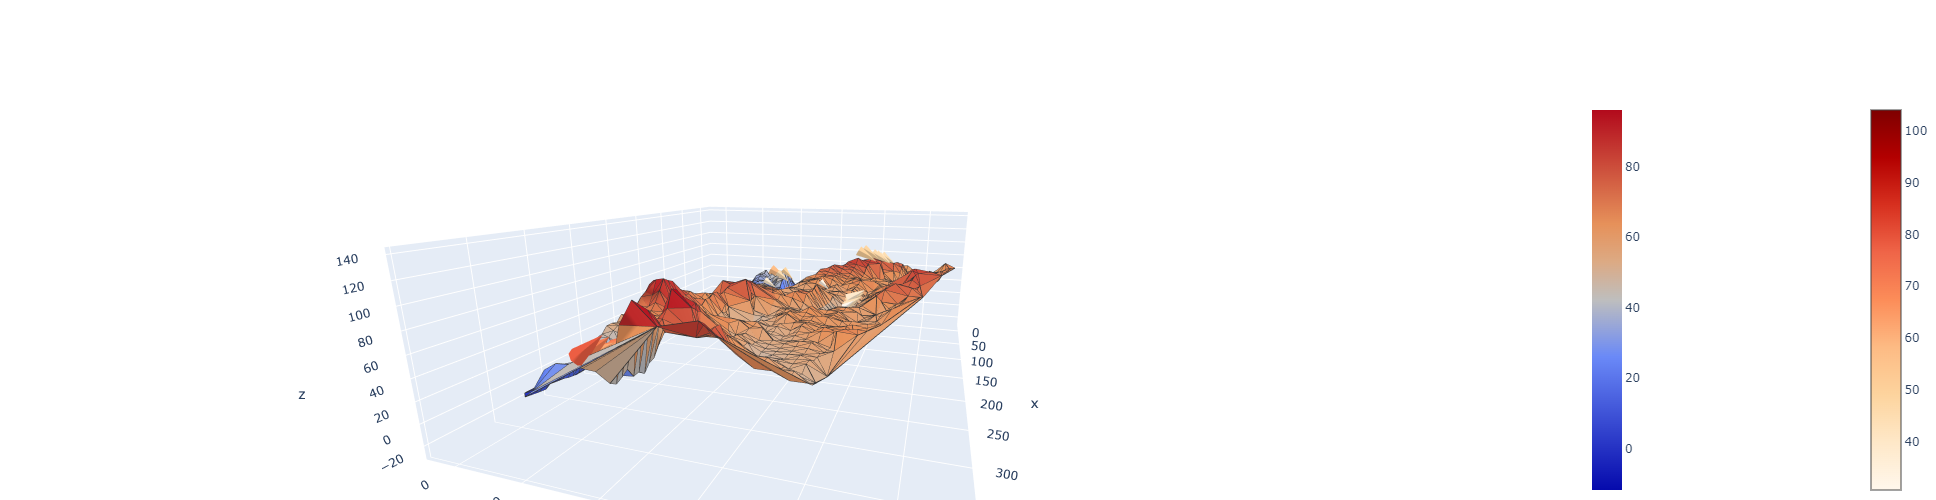

In [163]:
vec_data = go.Cone(x=x3d, y=y3d, z=z3d, u=u3d, v=v3d, w=w3d,
                   anchor='tail', colorscale='OrRd', sizemode='absolute', sizeref=2000,
                  colorbar=dict(x=1.2))
# Fig2 = go.Figure(vec_data)
surf_data = [triplot.data[i] for i in range(len(triplot.data))]
# cone_data = Fig2.data
total_data = surf_data + [vec_data]

Fig3 = go.Figure(total_data)
Fig3.update_layout(scene_camera_eye=dict(x=1.5, y=0.5, z=0.4),
                   width=800, height=500,
                   margin=dict(l=0, r=0, b=0, t=100))
Fig3.show()